1

In [ ]:
import keras
from keras import layers

import numpy as np
import random
import io

In [ ]:
path = keras.utils.get_file(
    "quran.txt",
    origin="https://www.gutenberg.org/cache/epub/2800/pg2800.txt",
)
with io.open(path, encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ")  # We remove newlines chars for nicer display
print("Corpus length:", len(text))

chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype="bool")
y = np.zeros((len(sentences), len(chars)), dtype="bool")
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

1161043/1161043 [==============================] - 0s 0us/step
Corpus length: 1133203
Total chars: 87
Number of sequences: 377721


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
epochs = 15
batch_size = 128

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.1, 0.5, 1.0]:
        print("...Diversity:", diversity)

        generated = ""
        sentence = text[start_index : start_index + maxlen]
        print('...Generating with seed: "' + sentence + '"')

        for i in range(200):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print("-")

2951/2951 [==============================] - 373s 126ms/step - loss: 1.6764

Generating text after epoch: 0
...Diversity: 0.1
...Generating with seed: "tend against the infidels and the hypocr"
...Generated:  ited the shall be the sent of the mercy the sent of the might of the might of the might of the sent of the sent of the sent of the sent of the shall be the sent of the might of the sent of the sent of
-
...Diversity: 0.5
...Generating with seed: "tend against the infidels and the hypocr"
...Generated:  ens and have been a tenged and the father became of the fammares shall can they believe in the been god, and they way ye be god and of god and let your lord.  he shall ye sussent of the refore that th
-
...Diversity: 1.0
...Generating with seed: "tend against the infidels and the hypocr"
...Generated:  iting thee, and obly; and the ever book that ye dlust a faith, and god fase thou a surel: and no piriviou; wise.  a dargay in an accorp. this ma-bidder treng:  how hadd not follow it 

2

In [7]:
# Transformers installation
#pip install transformers

from transformers import pipeline
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [8]:
txt1 = 'Scatman'
classifier(txt1)

[{'label': 'NEGATIVE', 'score': 0.9610628485679626}]

In [9]:
txt2 = 'Batman'
classifier(txt2)

[{'label': 'POSITIVE', 'score': 0.9962634444236755}]

3

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import tensorflow as tf
from keras.applications import vgg19

base_image_path = keras.utils.get_file("main.jpg", "https://cdn3.whatculture.com/images/2014/01/Tony-Stark.jpg")
style_reference_image_path = keras.utils.get_file(
    "style.jpg", "https://previews.123rf.com/images/delstudio/delstudio2304/delstudio230400113/201455424-generative-ai-night-scene-of-after-rain-city-in-cyberpunk-style-futuristic-nostalgic-80s-90s-neon.jpg"
)
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

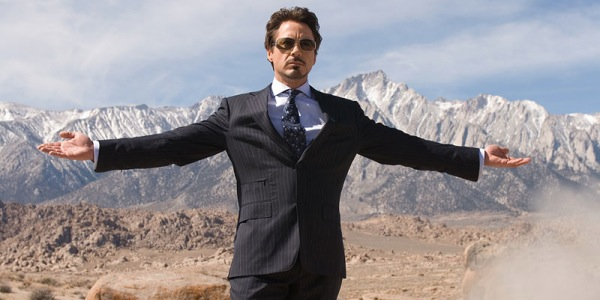

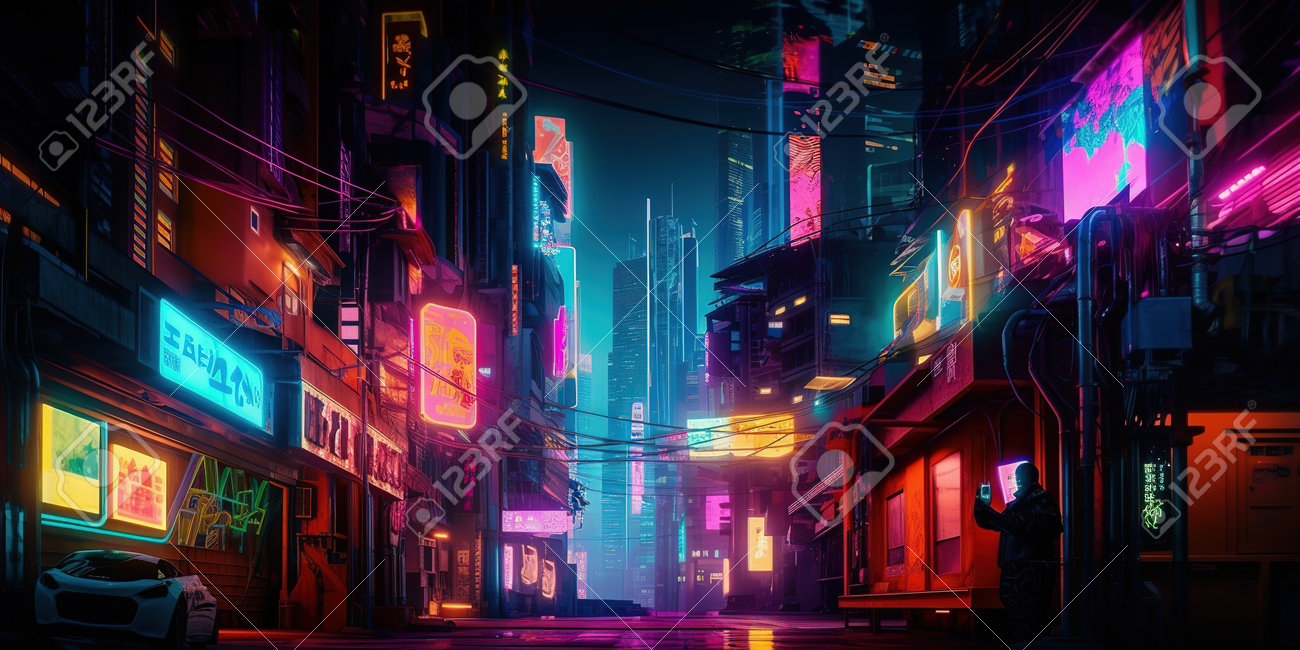

In [ ]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [ ]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [ ]:
model = vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.90
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 150
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 1 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

Iteration 1: loss=103866.12
Iteration 2: loss=86963.72
Iteration 3: loss=63157.71
Iteration 4: loss=46031.64
Iteration 5: loss=35191.77
Iteration 6: loss=28904.57
Iteration 7: loss=24795.81
Iteration 8: loss=21888.74
Iteration 9: loss=19689.50
Iteration 10: loss=17971.17
Iteration 11: loss=16606.98
Iteration 12: loss=15507.52
Iteration 13: loss=14603.28
Iteration 14: loss=13850.60
Iteration 15: loss=13206.16
Iteration 16: loss=12653.22
Iteration 17: loss=12165.02
Iteration 18: loss=11735.94
Iteration 19: loss=11351.11
Iteration 20: loss=11007.33
Iteration 21: loss=10695.31
Iteration 22: loss=10413.12
Iteration 23: loss=10154.10
Iteration 24: loss=9916.12
Iteration 25: loss=9696.26
Iteration 26: loss=9492.06
Iteration 27: loss=9302.06
Iteration 28: loss=9124.27
Iteration 29: loss=8957.86
Iteration 30: loss=8801.65
Iteration 31: loss=8654.88
Iteration 32: loss=8517.00
Iteration 33: loss=8386.47
Iteration 34: loss=8262.87
Iteration 35: loss=8145.63
Iteration 36: loss=8034.20
Iteration 37:

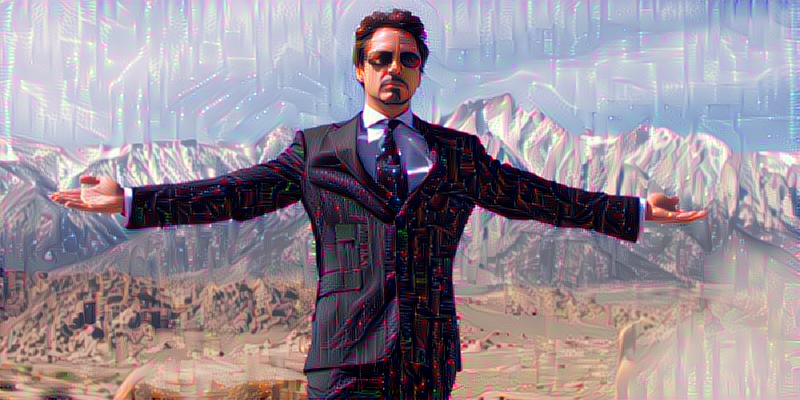

In [ ]:
display(Image(result_prefix + "_at_iteration_150.png"))